# Introduction to Artificial Neural Networks with TensorFlow

Let's look at a few different ways to implement a feedforward neural network (FNN) for the MNIST data using TensorFlow

In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

## Using tf.learn

The easiest way to train an Multilayer Perceptron (MLP) is with the high-level API TF.Learn, which is Scikit-Learn compatible.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets(os.getcwd() + "/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp

In [3]:
# Data is already scaled 
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [5]:
config = tf.contrib.learn.RunConfig()

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(
    hidden_units=[300,100],
    n_classes=10,
    feature_columns=feature_cols,
    config=config)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
dnn_clf.fit(X_train, y_train, batch_size=50, steps=10000)

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c31a3d710>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/vv/qydfyvc55ln7kwcv5wk7fbv80000gn/T/tmpzga6lru3'}
Instructions for updating:
P

INFO:tensorflow:loss = 0.15600574, step = 4301 (0.285 sec)
INFO:tensorflow:global_step/sec: 355.837
INFO:tensorflow:loss = 0.13481128, step = 4401 (0.280 sec)
INFO:tensorflow:global_step/sec: 348.169
INFO:tensorflow:loss = 0.017614914, step = 4501 (0.287 sec)
INFO:tensorflow:global_step/sec: 346.868
INFO:tensorflow:loss = 0.018871948, step = 4601 (0.289 sec)
INFO:tensorflow:global_step/sec: 341.908
INFO:tensorflow:loss = 0.013717109, step = 4701 (0.292 sec)
INFO:tensorflow:global_step/sec: 356.986
INFO:tensorflow:loss = 0.018513381, step = 4801 (0.280 sec)
INFO:tensorflow:global_step/sec: 279.6
INFO:tensorflow:loss = 0.07960994, step = 4901 (0.358 sec)
INFO:tensorflow:global_step/sec: 392.049
INFO:tensorflow:loss = 0.08244316, step = 5001 (0.255 sec)
INFO:tensorflow:global_step/sec: 361.055
INFO:tensorflow:loss = 0.00999899, step = 5101 (0.279 sec)
INFO:tensorflow:global_step/sec: 270.403
INFO:tensorflow:loss = 0.019646943, step = 5201 (0.369 sec)
INFO:tensorflow:global_step/sec: 379.4

SKCompat()

In [6]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /var/folders/vv/qydfyvc55ln7kwcv5wk7fbv80000gn/T/tmpzga6lru3/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.98

Got 98% accuracy on the MNIST test set -- better than any model we trained in ch3!

## Using plain TensorFlow and early stopping

In [20]:
n_inputs=28*28 #Size of MNIST image
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [21]:
X_valid = mnist.validation.images
y_valid = mnist.validation.labels
m, n = X_train.shape

In [22]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [23]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [24]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [25]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [26]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1) # 1D tensor of boolean values
    # Casting boolean to float and computing average to compute accuracy
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) 
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [27]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [28]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = os.getcwd() + "/tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}".format(root_logdir, name)

logdir = log_dir("mnist_ndd")

In [29]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [36]:
n_epochs = 200
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = os.getcwd() + "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.getcwd() + "/my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_val, loss_val, acc_summary_str, loss_summary_str = sess.run(
            [accuracy, loss, accuracy_summary, loss_summary],
            feed_dict={X: X_valid, y: y_valid})
        
        file_writer.add_summary(acc_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(acc_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                best_loss = loss_val
                saver.save(sess, final_model_path)
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Training was interrupted. Continuing at epoch 16
INFO:tensorflow:Restoring parameters from /Users/dhensle/Documents/dabbles-in-ML/oreilly/tmp/my_deep_mnist_model.ckpt
Epoch: 0 	Validation accuracy: 97.200% 	Loss: 0.10324
Epoch: 5 	Validation accuracy: 97.420% 	Loss: 0.08921
Epoch: 10 	Validation accuracy: 97.580% 	Loss: 0.08032
Epoch: 15 	Validation accuracy: 97.620% 	Loss: 0.07660
Epoch: 20 	Validation accuracy: 97.720% 	Loss: 0.07282
Epoch: 25 	Validation accuracy: 97.780% 	Loss: 0.07089
Epoch: 30 	Validation accuracy: 97.940% 	Loss: 0.06779
Epoch: 35 	Validation accuracy: 97.840% 	Loss: 0.06811
Epoch: 40 	Validation accuracy: 97.940% 	Loss: 0.06693
Epoch: 45 	Validation accuracy: 97.880% 	Loss: 0.06667
Epoch: 50 	Validation accuracy: 97.960% 	Loss: 0.06721
Epoch: 55 	Validation accuracy: 98.080% 	Loss: 0.06606
Epoch: 60 	Validation accuracy: 97.900% 	Loss: 0.06820
Epoch: 65 	Validation accuracy: 98.020% 	Loss: 0.06699
Epoch: 70 	Validation accuracy: 98.040% 	Loss: 0.06814
Epoch: 75 

In [37]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
print("Final accuracy on the test set:", accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/dhensle/Documents/dabbles-in-ML/oreilly/my_deep_mnist_model
Final accuracy on the test set: 0.9805


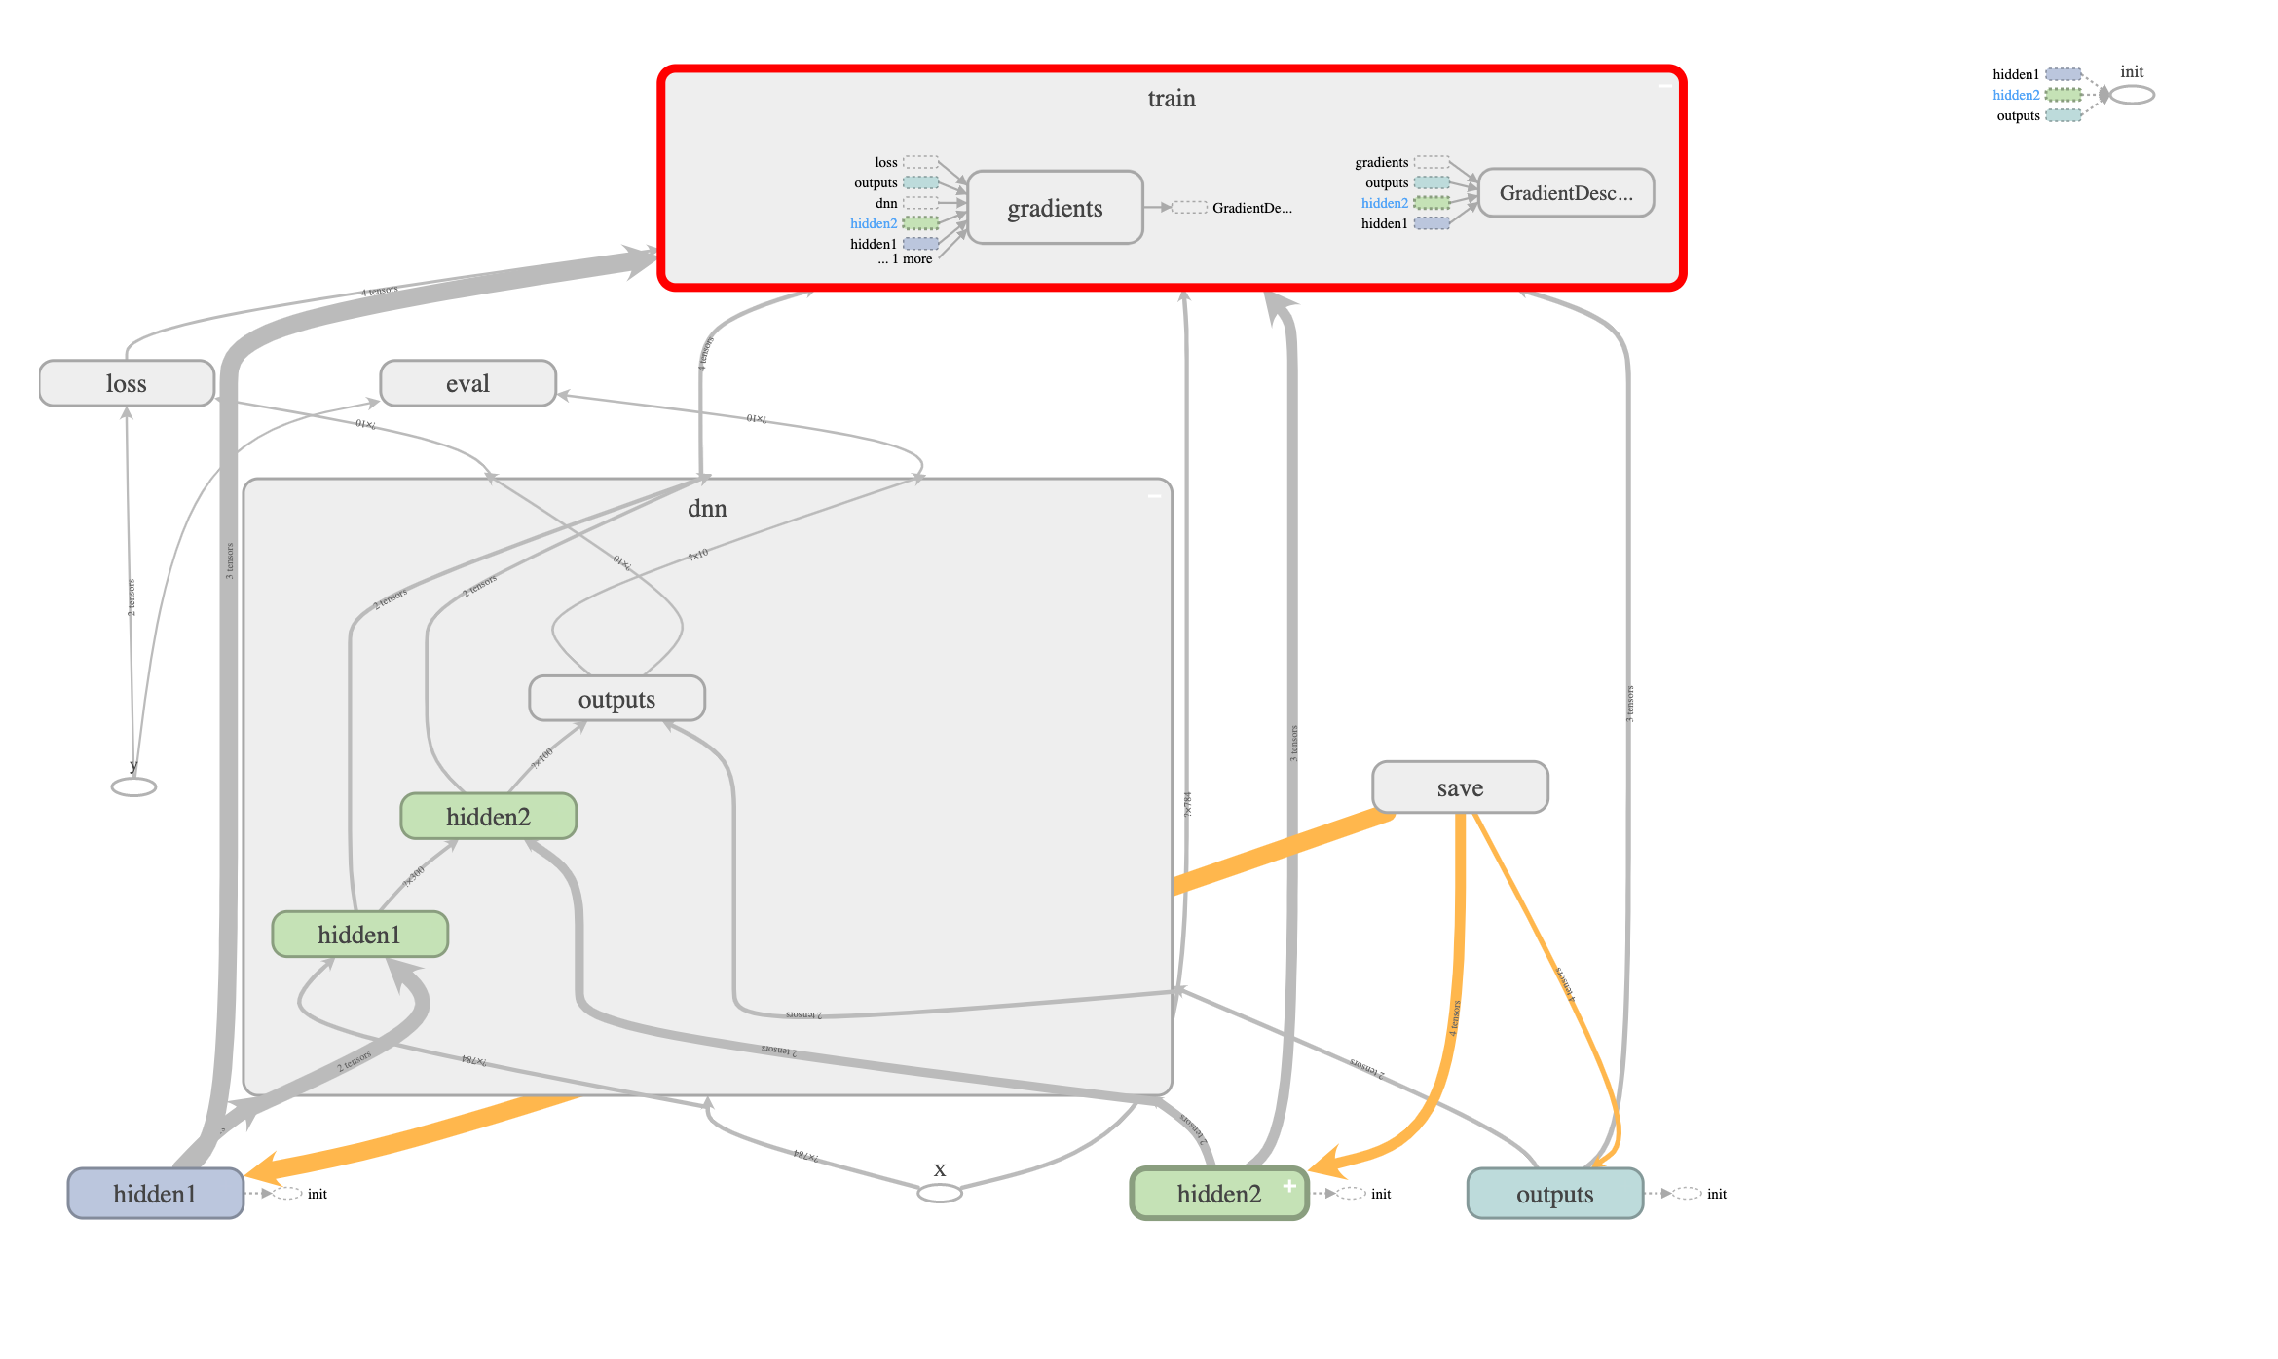

In [38]:
import matplotlib.image as mpimg
plt.figure(figsize=(40,40))
img = mpimg.imread(os.getcwd() + "/images/mnist_dnn_tensorboard.png")
plt.imshow(img)
plt.axis('off')
plt.show()

## What did we accomplish?

Implemented an MLP FNN on MNIST with 98% accuracy data using two approaches
1. a high-level, Scikit-Learn compatible FensorFlow API called TF.Learn
2. using plain TensorFlow with early stopping and Tensorboard visualization